# Ultra-High-Density Recording Explorer

- Analyze probe noise from saline recordings 
- Visualize impedance measurements and identify "bad" channels

## User Input

In [1]:
# Assumes this python notebook, the data file, and the imp. file are in same dir
impfile = 'impedance_20200403-111349.h5' # Impedance File
basefile = 'experiment_C20200403-111923.h5' # Saline baseline file
fs = 30000
chan_range = [0,64]
col_num = 3 # columns per shank
row_num = [22,20,22] # rows per column (# values should == # columns)

## Import Dependencies

In [2]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import HTML
from scipy.signal import butter, sosfiltfilt, sosfreqz
import time
import pandas as pd

## Read in impedence data
- Do not have the probe map from Jorg yet so don't know which channels correspond to dead sites (for wiring)
- Assume it's some of the ones with really high impedence but there are too many to say which ones.
- In the file below, 7,17,26,29,36,37,38,52,53 (from 0) on Shank1 are high 

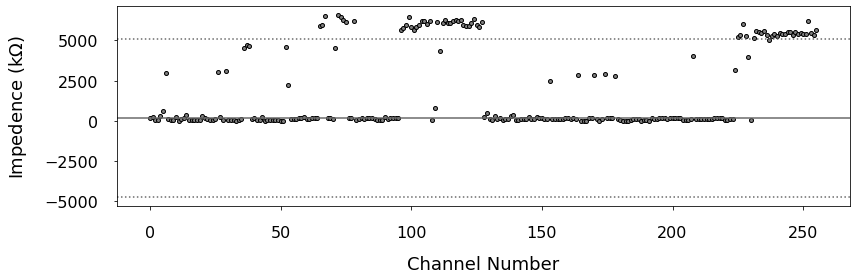

In [3]:
f_imp = h5py.File(impfile, 'r')

def get_impedence(f_imp):
    fig, ax = plt.subplots(figsize = (12,4))
    imp = f_imp['impedanceMeasurements'][:]
    x = np.where (imp > 0)[0]
    y = [imp[i] / 1000 for i in x] # kOhms
    ax.plot(x, y, ls = 'none', markersize = 4, marker = 'o', color = 'gray', mec = 'black')  
    ax.set_ylabel ('Impedence (k' + r'$\Omega$' + ')', fontsize = 18, labelpad = 15)
    ax.set_xlabel ('Channel Number', fontsize = 18, labelpad = 15)
    plt.tick_params(axis = 'both', which = 'major', pad = 15, labelsize = 16)
    med = np.median(y)
    rng = np.ptp(y)
    high = np.where(y > np.median(y) + rng * 0.75)[0]
    low = np.where (y < np.median(y)- rng * 0.75)[0]
    adj_y = [y1 for y1 in y if y1 not in low]
    adj_y = [y1 for y1 in y if y1 not in high]
    adj_high = np.where(y > np.median(adj_y) + rng * 0.75)[0]
    adj_low = np.where (y < np.median(adj_y) - rng * 0.75)[0]
    #ax.set_ylim(-200,500)
    report = {'avg': np.median(adj_y),
          'std': rng,
          'high': adj_high,
          'low' : adj_low}    
    
    display(HTML("<hr><h4>Median impedence = " + str(round(report['avg'],3)) + 
                 "<br> Range =  " + str(round(report['std'],3)) 
                 + '<br>' 
                 + "Channels with High Resistance (greater than 75% of median) =  "  
                 + str(report['high']).replace('[','').replace(']', '') + "<br>" +
                 "Channels with Low Resistance (less than 75% of median) = <br>" +
                str(report['low']).replace('[','').replace(']', '') +  "<hr color = 'gray'><br>"))
    
    ax.axhline(report['avg'], color = 'dimgray')
    ax.axhline(med + rng * 0.75, ls = ":", color = 'dimgray')
    ax.axhline(med - rng * 0.75, ls = ":", color = 'dimgray')

    plt.tight_layout()
    plt.savefig(impfile.replace('.h5', '_impedance.png'))
    
    return report, x, y
    
imp_report, channels, imp = get_impedence (f_imp)


## Read in the baseline probe data (saline recordings)
- for a 5 minute file it takes 10-30 mins
- keep checking for "dead kernel" errors
 - no dead kernel, it's still working

In [4]:
f_base = h5py.File(basefile, 'r')
x_subs = f_base.get('sample_index') # channel # (x)
subs = f_base.get('channel_data') # Get baseline y for all channels
subs = subs[:, channels] * 0.195 # Remove unconnected channels
display (HTML("<hr><h4>Data consists of " + str(subs.shape[1]) + 
              " columns of data (channels, x) and " + str(subs.shape[0]) 
              + " rows of data (measurements, y). Recording is " + 
              str(round(len(x_subs)/(fs * 60),2)) + " mins long. <hr>"))

## Get noise levels for unfiltered  probe data
- This will allow us to set thresholds for detecting neuronal activity vs background noise

In [5]:
window = [0, 30000]
channels = list(range(chan_range[0],chan_range[1]))
means = []
medians = []
sds = []
rngs = []

for chan in channels:
    means.append(np.mean(subs[window[0]:window[1], chan]))
    medians.append(np.median(subs[window[0]:window[1], chan]))
    sds.append(np.std(subs[window[0]:window[1], chan]))
    rngs.append(np.ptp(subs[window[0]:window[1], chan]))

unfiltered_stats = pd.DataFrame ({'means': means, 'medians': medians, 'sds': sds, 'rngs': rngs})
display(HTML(unfiltered_stats.head().to_html()))

,means,medians,sds,rngs
0,6389.567015,6389.565,6.405504,52.260
1,6389.566157,6390.150,7.053797,55.965
2,6389.618963,6389.760,4.282394,31.785
3,6389.385997,6389.370,4.158433,32.955
4,6389.338033,6389.565,7.376130,61.815


## Bandpass Filter (butterworth) of baseline probe data
- Have to analyze a subset of channels at a time or you get dead kernels 
- If recordings are very long, you can break it down into 64 channels at a time by changing subs[:, chan] to subs[0:64, chan] for the first 64 channels.uyoSimilarly, it could be subs[64:128, chan] or whatever length you need.

In [6]:
from scipy.signal import butter, sosfiltfilt, sosfreqz

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfiltfilt(sos, data)
        return y

def get_filtered (channels, df):
    lowcut = 400
    highcut = 5000
    display (HTML("<h4>Analyzing channel: "))
    for chan in channels:
        print(chan, end = ' ')
        order = 6
        x = np.arange(len(subs[:,chan]))
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        w, h = sosfreqz(sos, worN=2000)
        df[chan] = butter_bandpass_filter(subs[:,chan], lowcut, highcut, fs, order=order)
    return df

filtered = pd.DataFrame()
filtered = get_filtered(channels, filtered)   


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 

## Get noise level of filtered probe data

In [7]:
window = [0, 30000]
means = []
medians = []
sds = []
rngs = []

for chan in channels:
    means.append(np.mean(filtered[chan]))
    medians.append(np.median(filtered[chan]))
    sds.append(np.std(filtered[chan]))
    rngs.append(np.ptp(filtered[chan]))

filtered_stats = pd.DataFrame ({'means': means, 'medians': medians, 'sds': sds, 'rngs': rngs})
display(HTML(filtered_stats.head().to_html()))


,means,medians,sds,rngs
0,0.000042,0.005555,3.811244,38.361210
1,0.000044,-0.005340,3.609221,33.168638
2,0.000061,-0.000759,2.430833,36.805415
3,-0.000021,-0.002775,2.409816,31.250013
4,-0.000015,-0.001353,4.404856,39.872119


## Save the filtered probe data with stats
- This will make it easier to fetch the data later on without having to reload the whole thing
- This takes about 5-15 minutes per file 
- Datasets:
 - unfiltered_stats
 - filtered_stats
 - filtered_x
 - filtered_ y

In [8]:
# Add datasets to h5 file: impedance, median imp, range, 25th and 75th percentiles, mean noise from sub,
# potential bad channels filtered traces

hf_probe = h5py.File(basefile.replace('.h5', '_probe_' + str(chan_range[1] ) + '.h5'), 'w')
hf_probe.create_dataset('sample_index', data = filtered.iloc[:,0])
hf_probe.create_dataset('unfiltered_y', data = subs[:,channels])
hf_probe.create_dataset('channel_data', data = filtered.loc[:,channels])
hf_probe.create_dataset('unfiltered_stats', data = unfiltered_stats)
hf_probe.create_dataset('filtered_stats', data = filtered_stats)
hf_probe.close()

## Plot unfiltered probe data as grid

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 

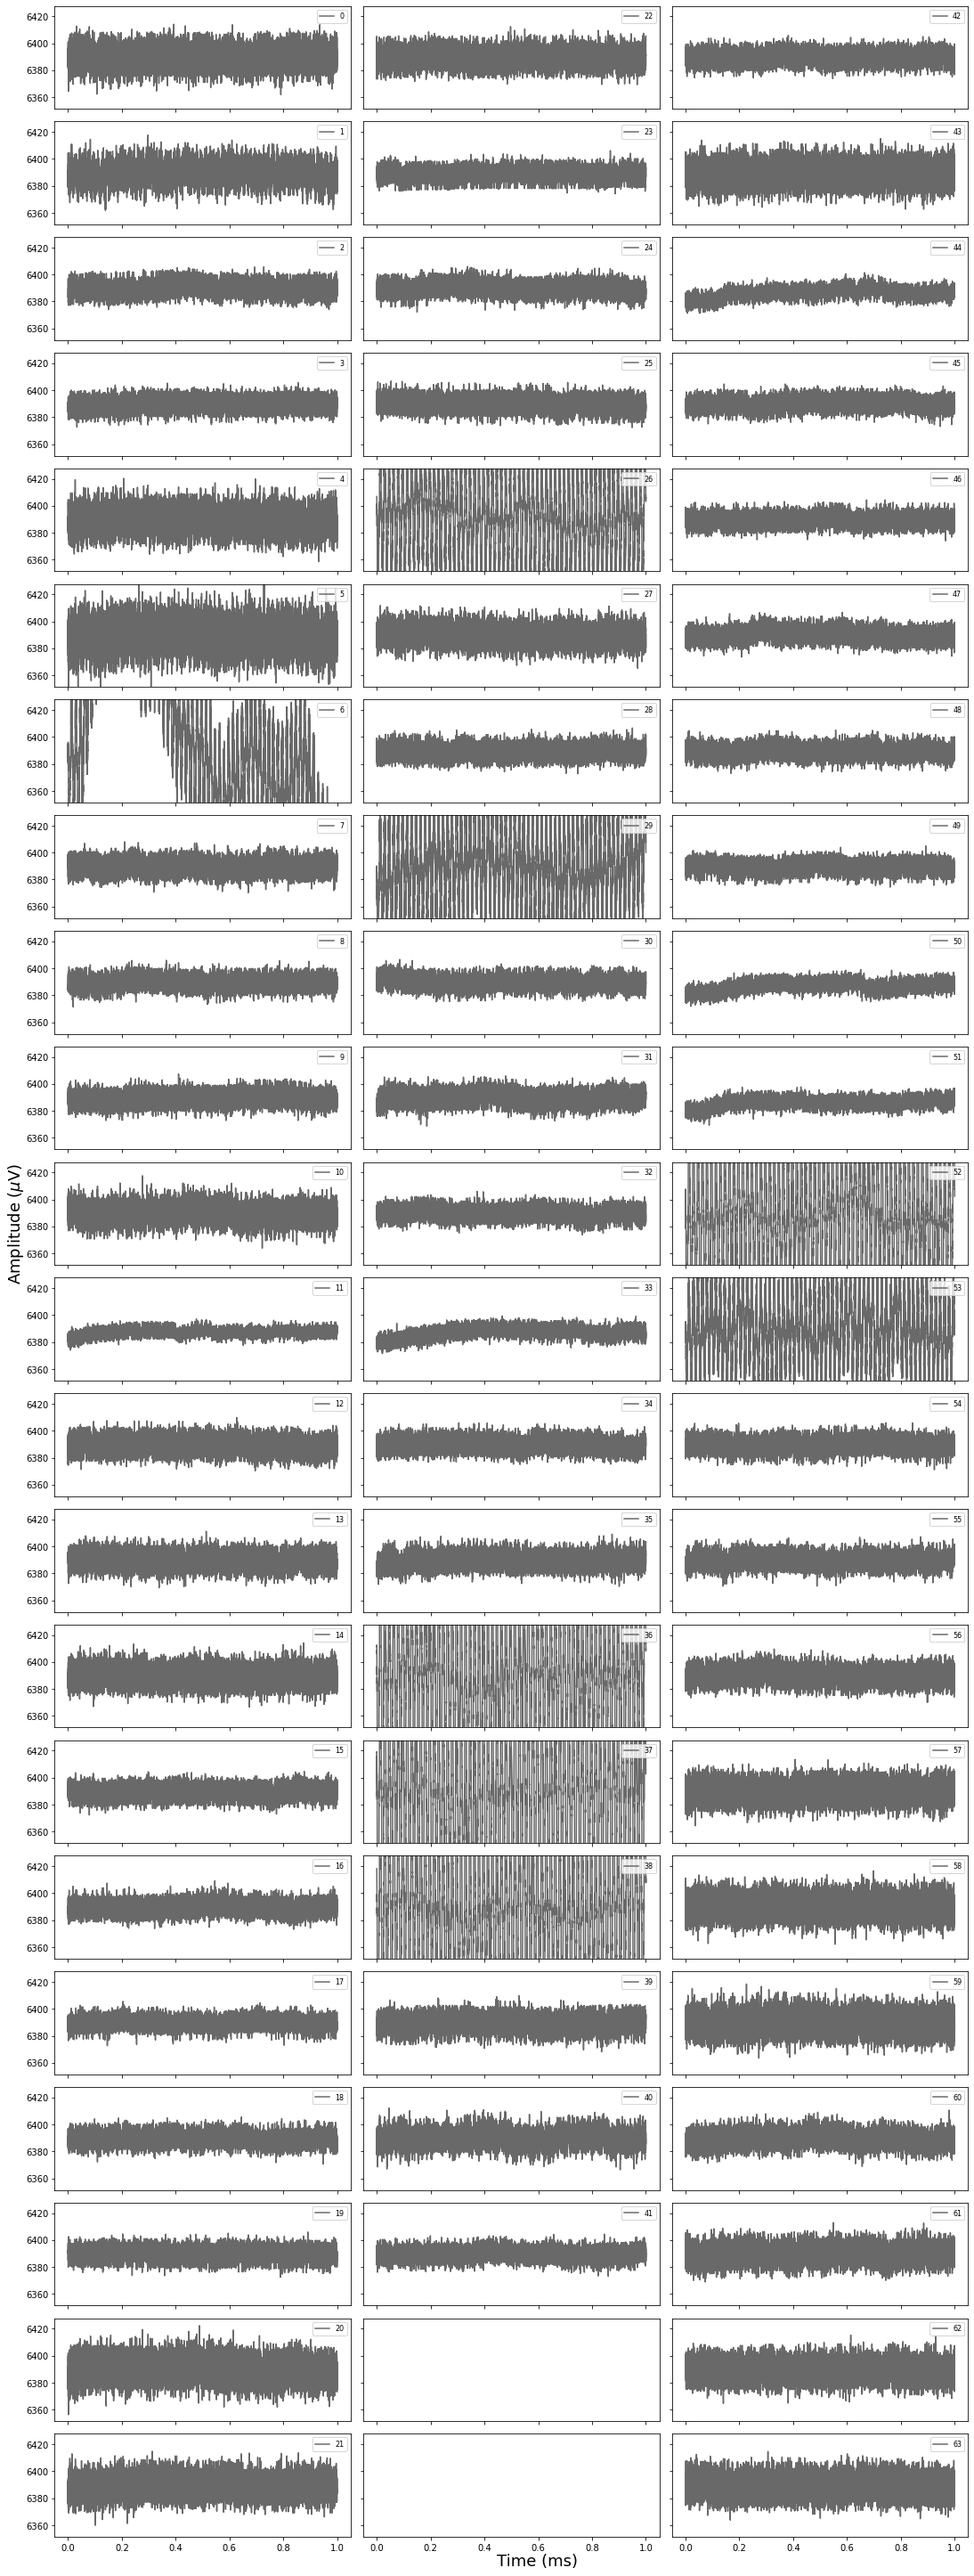

In [10]:
def grid_plot_unfiltered(chans, start, end):
    display(HTML('<hr><h4>Plotting channel: '))
    fig, ax = plt.subplots (max(row_num),len(row_num), figsize =(15,40), sharex = True, sharey = True)
    j = 0
    ch_num = 0
    for j in range (0,col_num):
        i = 0
        for i in range (0,row_num[j]): 
            print(ch_num, end = ' ')
            ax[i][j].plot(x_subs[start:end]/fs, subs[start:end,ch_num], color = 'dimgray', 
                            label=str(ch_num)) # Filtered Signal
            handles, labels = ax[i][j].get_legend_handles_labels()
            ax[i][j].legend(handles, labels, loc = 'upper right', fontsize = 8, shadow = False)
            #y_lims = ax[i][j].get_ylim()
            #ax[i][j].set_ylim(y_lims[0] - abs(y_lims[0]) * 0.1, y_lims[1] + abs(y_lims[1]) * 0.1)
            ax[i][j].set_ylim(unfiltered_stats.means[ch_num] - unfiltered_stats.rngs[ch_num]*0.75, 
                              unfiltered_stats.means[ch_num] + unfiltered_stats.rngs[ch_num]*0.75)
            #ax[i][j].set_title("Channel #" + str(chan) + ', Z = ' + str(round(imp[chan],2))  + r' M$\Omega$', fontsize = 20)
            #ax[i][j].tick_params (labelsize = 15)
            plt.tight_layout()
            ch_num = ch_num + 1
    fig.text(0.0, 0.5, r'Amplitude ($\mu$V)', ha='center', rotation='vertical', fontsize = 18)
    fig.text(0.5, 0.0, 'Time (ms)', va='center',  fontsize = 18)
    plt.savefig (basefile.replace('.h5','_probe_unfiltered_' + str(chan_range[1]) + '.png'))
    display(HTML('<hr>'))

shank_num = 1
win = [0,30000] 
chans = list(np.arange(0,shank_num*(col_num + sum(row_num))))
grid_plot_unfiltered(chans, win[0], win[1])

## Plot filtered probe data as grid

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 

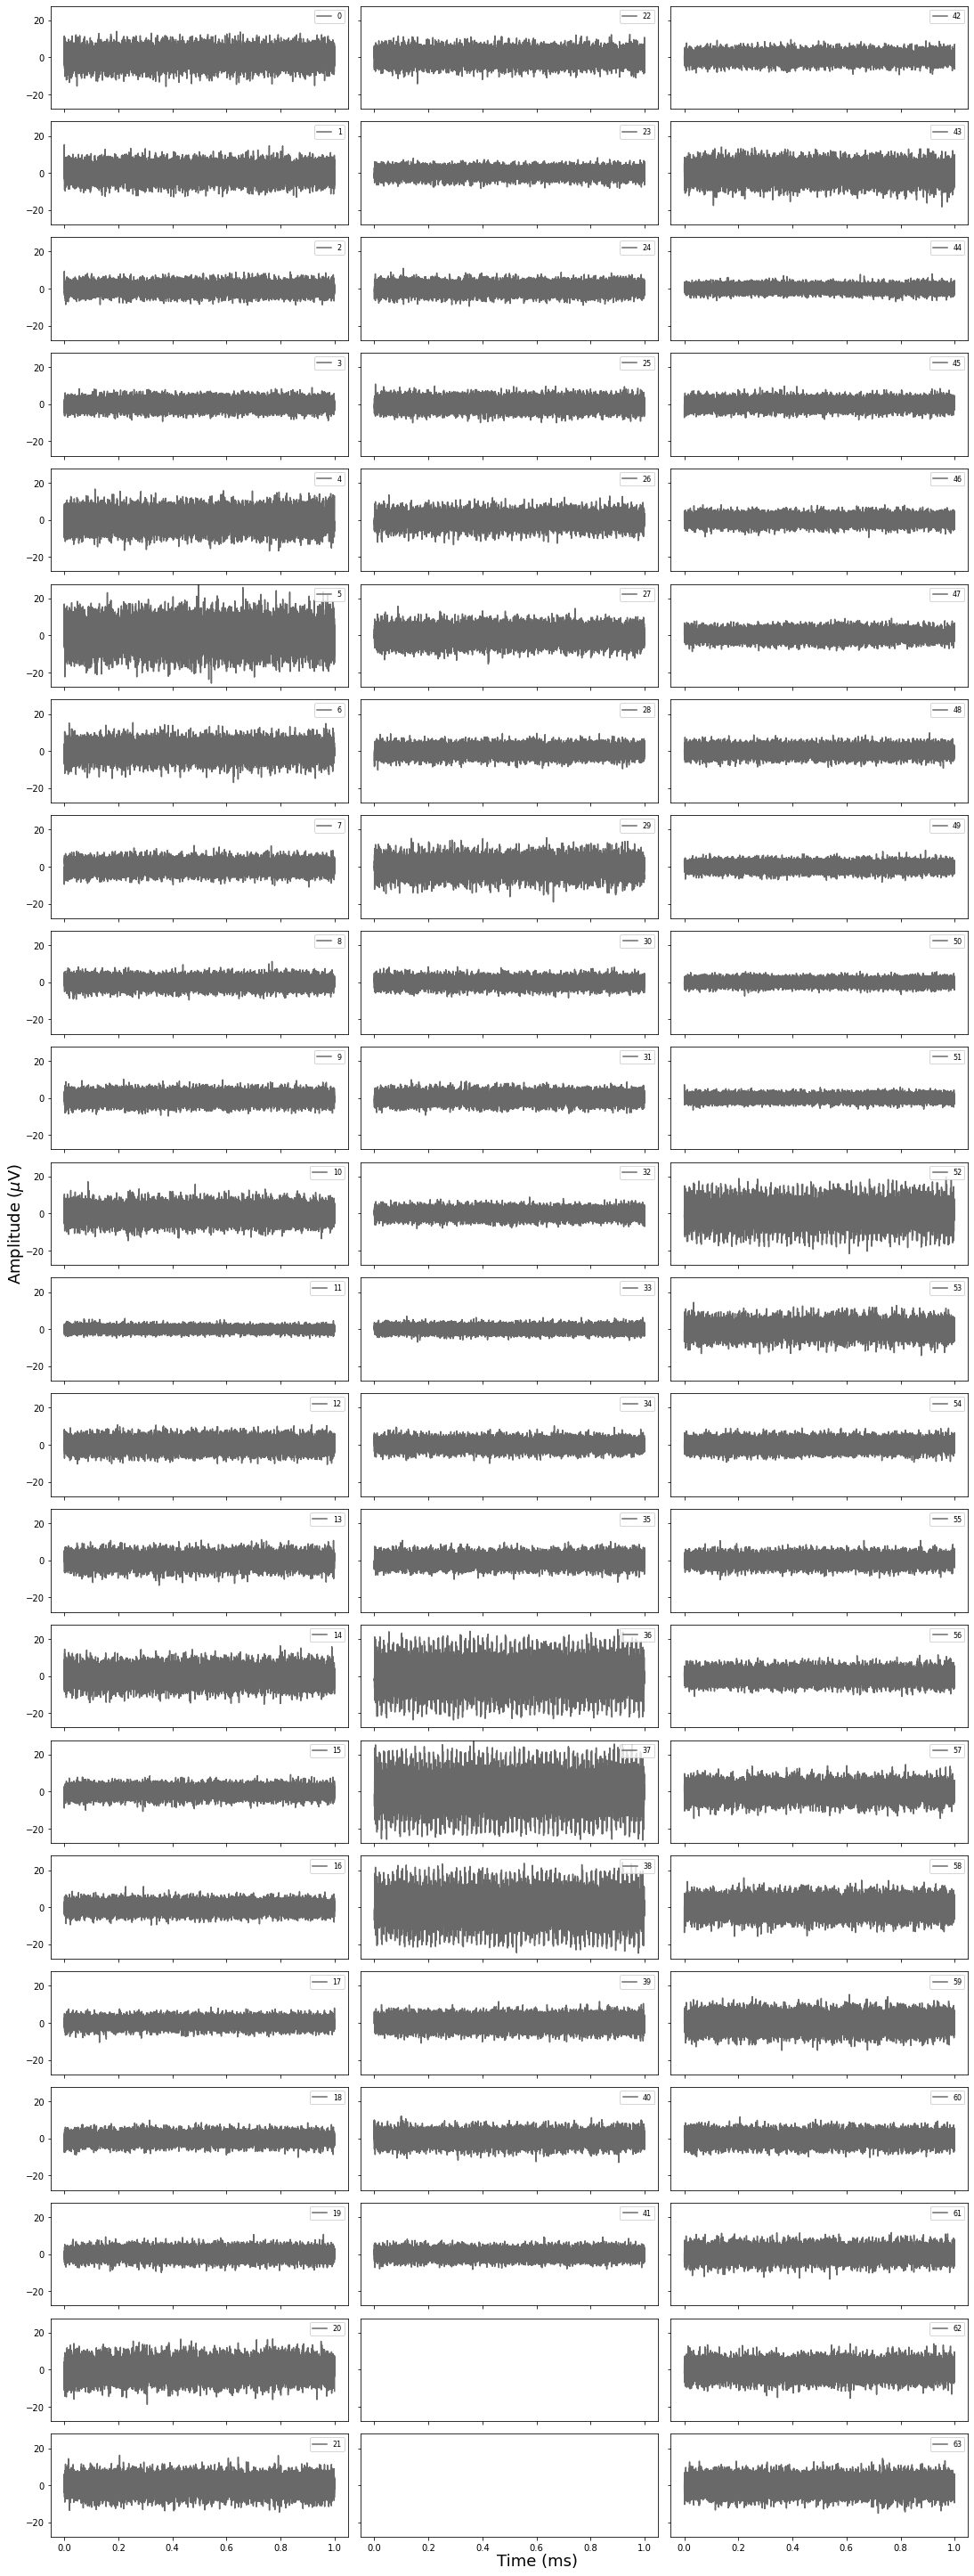

In [11]:
def grid_plot_filtered(chans, start, end, shank_num, filtered):
    display(HTML('<hr><h4>Plotting channel: '))
    fig, ax = plt.subplots (max(row_num),len(row_num), figsize =(15,40), sharex = True, sharey = True)
    j = 0
    ch_num = 0
    for j in range (0,col_num):
        i = 0
        for i in range (0,row_num[j]): 
            print(ch_num, end = ' ')
            ax[i][j].plot(x_subs[start:end]/fs, filtered.iloc[start:end,ch_num], color = 'dimgray', 
                            label=str(ch_num)) # Filtered Signal
            handles, labels = ax[i][j].get_legend_handles_labels()
            ax[i][j].legend(handles, labels, loc = 'upper right', fontsize = 8, shadow = False)
            #y_lims = ax[i][j].get_ylim()
            #ax[i][j].set_ylim(y_lims[0] - abs(y_lims[0]) * 0.1, y_lims[1] + abs(y_lims[1]) * 0.1)
            ax[i][j].set_ylim(filtered_stats.means[ch_num] - filtered_stats.rngs[ch_num]*0.75, 
                              filtered_stats.means[ch_num] + filtered_stats.rngs[ch_num]*0.75)
            #ax[i][j].set_title("Channel #" + str(chan) + ', Z = ' + str(round(imp[chan],2))  + r' M$\Omega$', fontsize = 20)
            #ax[i][j].tick_params (labelsize = 15)
            plt.tight_layout()
            ch_num = ch_num + 1
    fig.text(0.0, 0.5, r'Amplitude ($\mu$V)', ha='center', rotation='vertical', fontsize = 18)
    fig.text(0.5, 0.0, 'Time (ms)', va='center',  fontsize = 18)
    plt.savefig ('shank' + str(shank_num) + '_probe_filtered_' + str(chan_range[1]) + '.png')
    display(HTML('<hr>'))

shank_num = 1
win = [0,30000] 
chans = list(np.arange(0,shank_num*(col_num + sum(row_num))))
grid_plot_filtered(chans, win[0], win[1], 1, filtered)